## **Clustering SMLM Point Clouds from a Single Cluster using MIRO**

This tutorial demonstrates how to train and apply **MIRO** for clustering spatial point clouds from single-molecule localization microscopy (SMLM). We focus on the *single-shot training* setting, where the model is trained using just **one annotated cluster**. Specifically, we apply this minimal-data approach to scenarios 6 and 5 from the benchmarking dataset introduced in [Nieves et al., *Nature Methods* (2023)](https://www.nature.com/articles/s41592-022-01750-6), which provides a standardized framework for evaluating clustering methods in SMLM.

Although this tutorial centers on these two representative scenarios, the same methodology can be readily extended to other datasets in the benchmark or to custom SMLM data.



### **1. Load the data**


One of **MIRO**’s key strengths is its ability to learn from extremely limited data. While it typically generalizes well with just a few dozen representative clusters, it can still achieve reasonable performance when trained on a **single annotated cluster**.

To begin, we load the training cluster:


In [ ]:
import json
import pandas as pd

# Load the metadata associated with the dataset
with open("metadata.json") as f:
    metadata = json.load(f)

ID = 6
metadata = metadata[f"Ground Truth - Scenario {ID}"]
training_cluster = pd.read_csv(
    metadata["training_cluster_path"]
)

Next, we visualize the training cluster to better understand its structure and characteristics. 

This step is essential to verify that the data is suitable for training the **MIRO** model. Since we are using only a single cluster, its selection is especially important. It should be representative of the types of clusters we expect to encounter in the broader SMLM dataset.


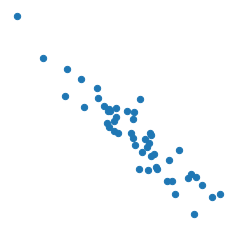

In [2]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
plt.scatter(
    training_cluster["x"],
    training_cluster["y"],
    s=40,
)
plt.axis("off")
plt.show()


### **2. Build the training dataset**


**MIRO** employs an augmentation pipeline that transforms the training cluster into a large number of diverse point clouds for training.

Each point cloud is generated by applying a series of transformations to randomly selected clusters, including geometric transformations (rotations, reflections), stochastic perturbations (localization dropout or addition), and spatial jitter (small random displacements).  These transformed clusters are then randomly placed within a synthetic FOV to generate the final training samples.

Importantly, these augmented point clouds are fitted to a normalized square region spanning from 0 to 1 , and **the training crop must be normalized** accordingly. This ensures that, when inserted into synthetic images during augmentation, the spatial scale of the clusters matches that of the validation data, preserving consistency in cluster size and density.

The following code initializes the **MIRO** data builder, which generates the augmented training dataset based on the extracted clusters and a set of metadata parameters. These metadata settings define key aspects of the synthetic dataset, such as the number of generated samples, the range of background noise points, the number of clusters per FOV, and the spatial connectivity radius used to define cluster compactness. 

You can inspect these settings by printing `metadata["builder_kwargs"]`. Once initialized, calling the builder returns a fully augmented dataset ready for training.


In [ ]:
import sys
from pathlib import Path

# Ensure the library path is in sys.path
lib_path = Path.cwd().parent.resolve()

if str(lib_path) not in sys.path:
    sys.path.insert(0, str(lib_path))

import lib

# Initialize the MIRO builder with the training clusters and metadata
builder = getattr(lib, metadata["builder"])(
    [training_cluster], **metadata["builder_kwargs"]
)
augmented_dataset = builder()

Let’s take a closer look at one of the augmented training images.

In **MIRO**, each training sample is represented as a **graph**, where nodes correspond to individual molecular localizations and edges are defined via Delaunay triangulation to capture local spatial relationships. You can use the following code to visualize one of these examples.

The colormap in the labeled scatter plot represents the magnitude of the **displacement vectors** from each node to its assigned cluster center. These vectors serve as the ground truth during training, enabling **MIRO** to learn transformations that contract structures toward a common center, effectively modeling the underlying cluster geometry.


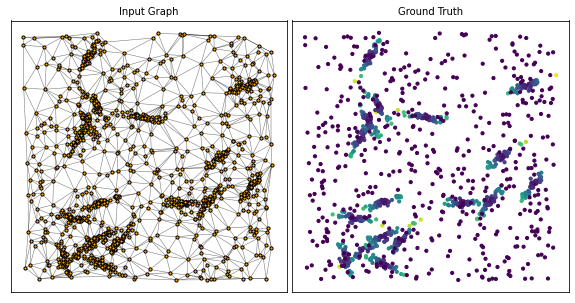

In [4]:
import numpy as np
import matplotlib.pyplot as plt

def plot_training_data(sample_idx):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    data = augmented_dataset[sample_idx]

    # Plot the graph representation
    for edge in data["edge_index"].T:
        x = [data["position"][edge[0]][0], data["position"][edge[1]][0]]
        y = [data["position"][edge[0]][1], data["position"][edge[1]][1]]
        ax[0].plot(x, y, color="black", linewidth=0.5, alpha=0.3)
    ax[0].scatter(
        data["position"][:, 0],
        data["position"][:, 1],
        s=10,
        zorder=2,
        c="orange",
        edgecolors="black",
    )
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    ax[0].set_title("Input Graph", fontsize=10)

    # Plot the ground truth displacement vectors
    ax[1].scatter(
        data["position"][:, 0],
        data["position"][:, 1],
        c=np.linalg.norm(data["y"], axis=1),
        s=10,
    )
    ax[1].set_xticks([])
    ax[1].set_yticks([])
    ax[1].set_title("Ground Truth", fontsize=10)

    plt.subplots_adjust(wspace=0.02)
    plt.show()


random_sample_idx = np.random.randint(0, len(augmented_dataset))
plot_training_data(random_sample_idx)

### **3. Create the model**


Now, instantiate **MIRO** using the configuration that matches the training data. 

The model is initialized with a set of key parameters: the number of output features (in this case, 2 for the predicted *x* and *y* displacements), the connectivity radius used to construct the input graphs (which should match the one used during augmentation), and the number of recurrent message-passing iterations to apply on the input graphs (set to 20 by default).

In [5]:
import deeplay as dl

clusterer = dl.MIRO(
    num_outputs=2,  # Number of output features (e.g., x, y displacements)
    connectivity_radius=builder.connectivity_radius,  # Radius for graph connectivity (matches dataset)
    num_iterations=metadata["recurrent_iterations"],  # Number of iterations for graph processing
)
clusterer = clusterer.create()

print(clusterer)

MIRO(
  (model): RecurrentMessagePassingModel(
    (encoder): Parallel(
      (0-1): 2 x MultiLayerPerceptron(
        (blocks): LayerList(
          (0): LinearBlock(
            (layer): LazyLinear(in_features=0, out_features=256, bias=True)
            (activation): Identity()
          )
        )
      )
    )
    (backbone): RecurrentGraphBlock(
      (combine): CatDictElements()
      (layer): Sequential(
        (0): Parallel(
          (0-1): 2 x MultiLayerPerceptron(
            (blocks): LayerList(
              (0): LinearBlock(
                (layer): LazyLinear(in_features=0, out_features=256, bias=True)
                (activation): Identity()
              )
            )
          )
        )
        (1): MessagePassingNeuralNetwork(
          (blocks): LayerList(
            (0): TransformPropagateUpdate(
              (transform): Transform(
                (combine): Cat()
                (layer): LazyLinear(in_features=0, out_features=256, bias=True)
             

### **4. Train the model**


Set up the data loaders and configure the training parameters.

In [ ]:
from torch_geometric.data import DataLoader

train_loader = DataLoader(
    dataset=augmented_dataset,  # The dataset to be loaded
    batch_size=4,  # Number of samples per batch
    shuffle=True,  # Shuffle the dataset at every epoch
)

# Initialize the trainer
trainer = dl.Trainer(max_epochs=30)  # Maximum number of training epochs

Finally, train **MIRO**. 

Alternatively, you can load a pre-trained model by setting `train_model = False`.

In [7]:
import torch

train_model = False

if train_model:
    trainer.fit(
        clusterer,  # The MIRO model to be trained
        train_loader,  # The DataLoader providing the training data
    )
else:
    clusterer.load_state_dict(torch.load(metadata["checkpoint"]))

### **5. Test the model**


Once training is complete, it’s time to evaluate **MIRO** on the validation dataset.

Use the code snippet below to load the validation data.

In [8]:
path = lib.sdownload(id=ID, local_folder="data", blinking=False)

Downloaded 'Ground Truth - Scenario 6' into C:\GU\miro_update\MIRO\single-shot\data\Ground Truth - Scenario 6


The following code reads the validation images and applies the trained model to perform clustering. 

The `clusterer` object includes a built-in `.clustering()` method, which automates the full inference pipeline. This method applies MIRO to each input graph, transforms the node features into the learned **squeezed representation** (where localizations belonging to the same cluster are pulled toward a common center) and runs DBSCAN on this transformed space to produce the final cluster assignments.

In [9]:
import re
from sklearn.cluster import DBSCAN

clusterer.eval()
clusterer.to("cuda" if torch.cuda.is_available() else "cpu")

pat = re.compile(r"\d+")
DIR = Path(path)
csv_files = sorted(DIR.glob("*.csv"), key=lambda f: int(pat.search(f.name).group()))

idx = {i - 1 for i in metadata["training_indices"]}
validation_paths = [f for j, f in enumerate(csv_files) if j not in idx]

vresults = []
for i, vpath in enumerate(validation_paths):
    vdata = pd.read_csv(vpath).copy()
    val_graph = lib.compute_test_graph(vdata, builder)

    clusters = clusterer.clustering(
        val_graph,  # Input graph representing the validation point cloud
        eps=metadata["MIRO_DBSCAN_params"][
            "eps"
        ],  # DBSCAN epsilon parameter for neighborhood radius
        min_samples=metadata["MIRO_DBSCAN_params"][
            "min_samples"
        ],  # DBSCAN minimum samples parameter for core points
        scaling=vdata[["x", "y"]]
        .max()
        .values,  # Used to convert displacements back to the original coordinate scale
    )

    dbclusters = DBSCAN(
        eps=metadata["DBSCAN_params"]["eps"],
        min_samples=metadata["DBSCAN_params"]["min_samples"],
    ).fit_predict(vdata[["x", "y"]])

    vdata["clustering-MIRO"] = clusters + 1
    vdata["clustering-DBSCAN"] = dbclusters + 1
    vdata["set"] = i
    vresults.append(vdata)

vresults = pd.concat(vresults, ignore_index=True)

Let’s now compute the average evaluation metrics across the 47 validation images. These include `ARI_values` and `AMI_values`, along with class-imbalance-aware variants such as `ARI_c_values` and `ARI_dagger_values`. We also report `IoU_values` to assess cluster overlap, as well as cluster-level metrics like `JIc_values`, `RMSRE_N_values`, and `RMSE_centr_values`.


In [10]:
results = lib.calculate_metrics_for_experiments(vresults)
aresults = results.groupby('class_names').mean().reset_index().round(2)

aresults = aresults.drop(columns=['experiment'])
aresults = aresults.set_index('class_names').transpose()
aresults.columns.name = None

print("Average Results:")
print(aresults)

  0%|          | 0/47 [00:00<?, ?it/s]

Average Results:
                   DBSCAN  MIRO
IoU_values           0.57  0.66
ARI_values           0.73  0.75
ARI_c_values         0.66  0.88
ARI_dagger_values    0.66  0.73
AMI_values           0.73  0.79
JIc_values           0.67  0.96
RMSRE_N_values       0.54  0.25
RMSE_centr_values    4.60  3.43


Finally, we visualize a randomly selected validation image along with its predicted cluster assignments from DBSCAN, MIRO-enhanced DBSCAN, and the ground truth labels.

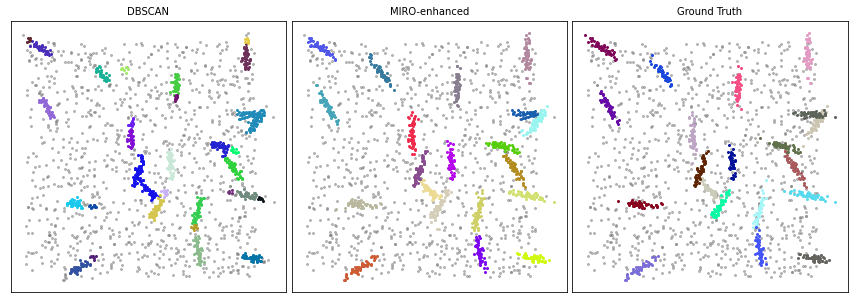

In [14]:
def plot_clustering_results(results):
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))

    # Titles for each subplot
    titles = ["DBSCAN", "MIRO-enhanced", "Ground Truth"]

    # Loop through each clustering method and visualize results
    for i, c in enumerate(["clustering-DBSCAN", "clustering-MIRO", "index"]):
        clustering = results[c].copy()
        ax[i].set_xticks([])  # Remove x-axis ticks for a cleaner plot
        ax[i].set_yticks([])  # Remove y-axis ticks for a cleaner plot
        ax[i].set_title(titles[i], fontsize=10)  # Set title for the subplot

        # Iterate through unique cluster labels
        for u in np.unique(clustering):
            if u == 0:  # Background points (label 0)
                ax[i].scatter(
                    results["x"][results[c] == u],  # x-coordinates of background points
                    results["y"][results[c] == u],  # y-coordinates of background points
                    s=4,  # Point size
                    c="gray",  # Background color
                    alpha=0.5,  # Transparency for background points
                )
            else:  # Clustered points
                ax[i].scatter(
                    results["x"][results[c] == u],  # x-coordinates of clustered points
                    results["y"][results[c] == u],  # y-coordinates of clustered points
                    s=4,  # Point size
                    color=np.random.rand(3),  # Random RGB color for each cluster
                )
    plt.subplots_adjust(wspace=0.02)  # Adjust spacing between subplots
    plt.show()


validation_image = vresults[
    vresults["set"] == np.random.choice(vresults["set"].unique())
].copy()
plot_clustering_results(validation_image)